# Run experiments

In [1]:
from audiointerp.dataset.esc50 import ESC50dataset
from audiointerp.model.cnn14 import TransferCnn14
from audiointerp.fit import Trainer
from audiointerp.processing.spectrogram import LogMelSTFTSpectrogram
from audiointerp.interpretation.saliency import SaliencyInterpreter
from audiointerp.interpretation.gradcam import GradCAMInterpreter
from audiointerp.interpretation.shap import SHAPInterpreter
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torchaudio.transforms as T_audio
import torchvision.transforms as T_vision
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import numpy as np
from IPython.display import Audio
from audiointerp.predict import Predict
from audiointerp.metrics import Metrics

/home/yuliya/coursework24/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_learning_curves(train_losses, val_losses, train_accs=None, val_accs=None):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    if val_losses:
        plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    plt.subplot(1, 2, 2)
    if train_accs is not None:
        plt.plot(epochs, train_accs, label="Train Acc")
    if val_accs is not None:
        plt.plot(epochs, val_accs, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [3]:
root_dir = "/home/yuliya/ESC50"
sr = 32000
train_folds = [1, 2, 3]
valid_folds = [4]
test_folds = [5]

In [4]:
n_fft = 1024
hop_length = 320
win_length = 1024
n_mels = 64
f_min = 50
f_max = 14000
top_db = 80

In [5]:
feature_extractor_fit = LogMelSTFTSpectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length,
    sample_rate=sr, n_mels=n_mels, f_min=f_min, f_max=f_max, top_db=top_db,
    return_phase=False, return_full_db=False
)

In [6]:
feature_extractor_predict = LogMelSTFTSpectrogram(
    n_fft=n_fft, win_length=win_length, hop_length=hop_length,
    sample_rate=sr, n_mels=n_mels, f_min=f_min, f_max=f_max, top_db=top_db,
    return_phase=True, return_full_db=True
)

In [7]:
feature_augs = nn.Sequential(
    T_audio.FrequencyMasking(20),
    T_audio.TimeMasking(20)
)

In [8]:
train_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=train_folds, normalize="peak", feature_extractor=feature_extractor_fit, feature_augs=feature_augs)
valid_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=valid_folds, normalize="peak", feature_extractor=feature_extractor_fit)
test_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=test_folds, normalize="peak", feature_extractor=feature_extractor_fit)

In [9]:
train_loader_kwargs = {"batch_size": 32, "shuffle": True}
valid_loader_kwargs = {"batch_size": 32, "shuffle": False}
test_loader_kwargs = {"batch_size": 32, "shuffle": False}

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cls = TransferCnn14
model_kwargs = {"num_classes": 50}
model_pretrain_weights_path = "weights/Cnn14_mAP=0.431.pth"

optimizer_cls = optim.Adam
optimizer_kwargs = {"lr": 1e-4}

criterion_cls = nn.CrossEntropyLoss
use_mixup = True
mixup_alpha = 0.2

In [11]:
model_trainer = Trainer(
    model_cls=model_cls,
    train_data=train_data,
    train_loader_kwargs=train_loader_kwargs,
    criterion_cls=criterion_cls,
    optimizer_cls=optimizer_cls,
    model_kwargs=model_kwargs,
    model_pretrain_weights_path=model_pretrain_weights_path,
    optimizer_kwargs=optimizer_kwargs,
    device=device,
    valid_data=valid_data,
    valid_loader_kwargs=valid_loader_kwargs,
    test_data=test_data,
    test_loader_kwargs=test_loader_kwargs,
    use_mixup=use_mixup,
    mixup_alpha=mixup_alpha
)

Random seed set to: 42


In [ ]:
train_losses, train_accs, val_losses, val_accs, test_loss, test_acc = model_trainer.train(num_epochs=20)

Epoch:   5%|▌         | 1/20 [00:40<12:51, 40.63s/it]

Train Loss: 3.8838, Train Acc: 0.0443
Valid Loss: 3.7438, Valid Acc: 0.1550


Epoch:  10%|█         | 2/20 [01:23<12:40, 42.22s/it]

Train Loss: 3.6654, Train Acc: 0.1361
Valid Loss: 3.3127, Valid Acc: 0.5200


Epoch:  15%|█▌        | 3/20 [02:09<12:20, 43.54s/it]

Train Loss: 3.0176, Train Acc: 0.3261
Valid Loss: 1.9327, Valid Acc: 0.7150


Epoch:  20%|██        | 4/20 [02:56<12:03, 45.24s/it]

Train Loss: 2.1878, Train Acc: 0.4690
Valid Loss: 0.9843, Valid Acc: 0.8175


Epoch:  25%|██▌       | 5/20 [03:40<11:07, 44.50s/it]

Train Loss: 1.6977, Train Acc: 0.5879
Valid Loss: 0.6061, Valid Acc: 0.8750


Epoch:  30%|███       | 6/20 [04:25<10:25, 44.70s/it]

Train Loss: 1.3186, Train Acc: 0.6975
Valid Loss: 0.4878, Valid Acc: 0.8950


Epoch:  35%|███▌      | 7/20 [05:10<09:42, 44.84s/it]

Train Loss: 1.2357, Train Acc: 0.7573
Valid Loss: 0.4353, Valid Acc: 0.9050


Epoch:  40%|████      | 8/20 [05:55<09:00, 45.02s/it]

Train Loss: 1.2417, Train Acc: 0.7562
Valid Loss: 0.4052, Valid Acc: 0.9150


Epoch:  45%|████▌     | 9/20 [06:41<08:18, 45.29s/it]

Train Loss: 0.9597, Train Acc: 0.8132
Valid Loss: 0.3229, Valid Acc: 0.9275


Epoch:  50%|█████     | 10/20 [07:28<07:38, 45.87s/it]

Train Loss: 1.1448, Train Acc: 0.7768
Valid Loss: 0.3407, Valid Acc: 0.9250


Epoch:  55%|█████▌    | 11/20 [08:13<06:50, 45.63s/it]

Train Loss: 1.1409, Train Acc: 0.7646
Valid Loss: 0.3313, Valid Acc: 0.9175


Epoch:  60%|██████    | 12/20 [08:59<06:05, 45.71s/it]

Train Loss: 0.9219, Train Acc: 0.8162
Valid Loss: 0.2994, Valid Acc: 0.9275


Epoch:  65%|██████▌   | 13/20 [09:48<05:25, 46.53s/it]

Train Loss: 0.8704, Train Acc: 0.8341
Valid Loss: 0.2904, Valid Acc: 0.9300


Epoch:  70%|███████   | 14/20 [10:33<04:37, 46.27s/it]

Train Loss: 0.9663, Train Acc: 0.8240
Valid Loss: 0.2938, Valid Acc: 0.9225


Epoch:  75%|███████▌  | 15/20 [11:18<03:49, 45.93s/it]

Train Loss: 0.9562, Train Acc: 0.8280
Valid Loss: 0.2881, Valid Acc: 0.9275


Epoch:  80%|████████  | 16/20 [12:11<03:12, 48.03s/it]

Train Loss: 0.8694, Train Acc: 0.8397
Valid Loss: 0.2982, Valid Acc: 0.9300


Epoch:  85%|████████▌ | 17/20 [12:55<02:20, 46.80s/it]

Train Loss: 0.9712, Train Acc: 0.8397
Valid Loss: 0.3077, Valid Acc: 0.9350


Epoch:  90%|█████████ | 18/20 [13:39<01:31, 45.88s/it]

Train Loss: 0.8365, Train Acc: 0.8515
Valid Loss: 0.2787, Valid Acc: 0.9300


Epoch:  95%|█████████▌| 19/20 [14:26<00:46, 46.25s/it]

Train Loss: 1.1698, Train Acc: 0.7815
Valid Loss: 0.3075, Valid Acc: 0.9300


Epoch: 100%|██████████| 20/20 [15:10<00:00, 45.55s/it]


Train Loss: 0.8988, Train Acc: 0.8353
Valid Loss: 0.2837, Valid Acc: 0.9325
Best val Acc: 0.9350
Модель сохранена в best.pth
Test Loss: 0.3285, Test Acc: 0.9175


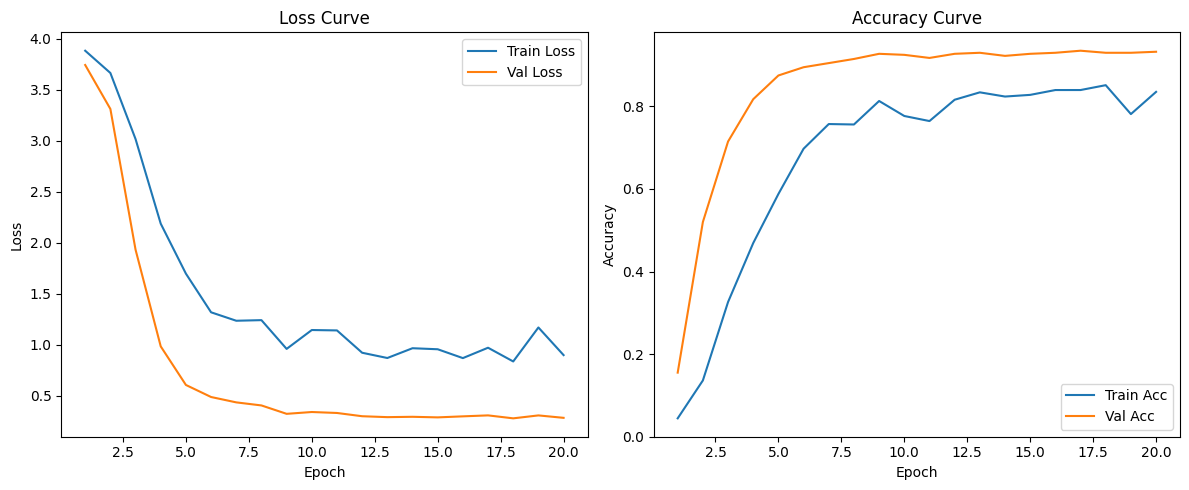

In [19]:
plot_learning_curves(train_losses=train_losses, train_accs=train_accs, val_losses=val_losses, val_accs=val_accs)

In [12]:
model = TransferCnn14(num_classes=50)
model.load_state_dict(torch.load("best.pth"))
model.to(device)

TransferCnn14(
  (base): Cnn14(
    (bn0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_block1): ConvBlock(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block2): ConvBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_block3): ConvBlock(
      (conv1): Conv2d(128, 

___

In [13]:
shap_background_folds = [1]

In [14]:
def get_balanced_background(dataloader, num_samples_per_class=2, device="cpu"):
    from collections import defaultdict
    class_to_samples = defaultdict(list)
    
    for batch_x, batch_y in dataloader:
        for x, y in zip(batch_x, batch_y):
            if len(class_to_samples[y.item()]) < num_samples_per_class:
                class_to_samples[y.item()].append(x.unsqueeze(0))
    
    background_tensors = []
    for class_label, tensor_list in class_to_samples.items():
        background_tensors.extend(tensor_list)
    
    background = torch.cat(background_tensors, dim=0).to(device)
    return background

In [15]:
test_data_predict = ESC50dataset(root_dir=root_dir, sr=sr, folds=test_folds, normalize="peak")
test_loader_predict = DataLoader(test_data_predict, batch_size=32, shuffle=False)
train_data_shap = ESC50dataset(root_dir=root_dir, sr=sr, folds=shap_background_folds, normalize="peak", feature_extractor=feature_extractor_fit)
train_loader_shap = DataLoader(train_data_shap, batch_size=100, shuffle=False)
shap_background = get_balanced_background(train_loader_shap, num_samples_per_class=1, device=device)

In [16]:
shap_exp = SHAPInterpreter(model, shap_background[:10])

In [17]:
predict_saliency = Predict(model, feature_extractor_predict, interp_method_cls=SaliencyInterpreter, interp_method_kwargs={}, device=device)
predict_gradcam = Predict(model, feature_extractor_predict, interp_method_cls=GradCAMInterpreter, interp_method_kwargs={"target_layers": [model.base.conv_block6.conv2]}, device=device)

In [18]:
results_saliency = predict_saliency.predict_set(test_loader_predict)

In [19]:
results_saliency

{'FF': tensor([0.8077, 0.0093, 0.4559, 0.4496, 0.7476, 0.4543, 0.4983, 0.2825, 0.5844,
         0.3380, 0.7048, 0.9459, 0.8650, 0.6332, 0.5146, 0.9230, 0.2561, 0.9051,
         0.7431, 0.3595, 0.2254, 0.5450, 0.9118, 0.9563, 0.7220, 0.9413, 0.8180,
         0.8464, 0.2620, 0.2609, 0.6608, 0.6360, 0.9112, 0.9051, 0.8025, 0.7400,
         0.5978, 0.9448, 0.8796, 0.8009, 0.5102, 0.9858, 0.8001, 0.9620, 0.9286,
         0.8328, 0.8383, 0.8009, 0.2919, 0.9073, 0.8509, 0.1833, 0.1861, 0.8671,
         0.3791, 0.7522, 0.3355, 0.9061, 0.9920, 0.3931, 0.1302, 0.6897, 0.7908,
         0.8462, 0.8196, 0.8553, 0.6638, 0.9008, 0.9107, 0.5166, 0.7070, 0.6195,
         0.7522, 0.9434, 0.9194, 0.9161, 0.9333, 0.9066, 0.9492, 0.9320, 0.6182,
         0.8260, 0.9798, 0.7568, 0.6226, 0.5947, 0.6700, 0.8223, 0.2189, 0.8102,
         0.0385, 0.8988, 0.4695, 0.9247, 0.9589, 0.8276, 0.7672, 0.3839, 0.4931,
         0.7482, 0.9073, 0.6960, 0.5870, 0.4976, 0.8659, 0.9302, 0.9341, 0.4349,
         0.7120, 0.967

In [20]:
for m in results_saliency:
    print(f"{m}: {results_saliency[m].nanmean().item()}")

FF: 0.6791847944259644
AI: 0.0
AD: 93.1441879272461
AG: 0.0
FidIn: 0.10499999672174454
SPS: 0.7831902037963887
COMP: 9.07891243750019


In [21]:
results_gradcam = predict_gradcam.predict_set(test_loader_predict)

/home/yuliya/coursework24/env/lib/python3.12/site-packages/quantus/metrics/complexity/complexity.py:254: RuntimeWarning: invalid value encountered in divide
  a = np.array(np.reshape(a, newshape), dtype=np.float64) / np.sum(np.abs(a))


In [22]:
results_gradcam

{'FF': tensor([ 5.8764e-01, -3.3773e-05,  1.5085e-01,  1.0937e-05,  5.2657e-01,
          3.7124e-01, -2.5295e-02,  5.5869e-01,  1.3183e-01,  1.2811e-01,
          1.6749e-05,  7.3803e-01,  3.8368e-03, -7.5783e-03,  1.5747e-01,
          3.4484e-03,  2.2451e-01,  1.9666e-01, -3.6100e-02, -4.2894e-02,
          3.4534e-02, -1.2147e-01,  2.4931e-01,  3.1264e-01,  7.3136e-01,
          1.4362e-02,  8.4856e-01, -1.0041e-01, -4.1117e-02,  4.2418e-02,
          3.4450e-02,  1.1137e-02,  7.0682e-02,  4.3572e-01,  1.7106e-01,
          6.3640e-01, -2.0046e-02,  2.2881e-02,  1.3371e-01,  2.9576e-01,
          1.7948e-01,  6.1287e-02,  7.1375e-01, -1.1793e-02,  2.5242e-01,
          6.5322e-01,  5.4376e-02,  1.5936e-01, -1.5068e-04,  6.9745e-01,
          8.7252e-03,  2.4476e-01,  6.4259e-02, -5.3338e-02,  2.2209e-01,
          4.8217e-01,  3.0998e-01,  7.6364e-01,  4.0360e-02, -2.3479e-02,
         -4.3824e-02,  2.7812e-04,  7.7695e-04, -4.2242e-04,  8.1658e-06,
          5.2904e-02,  5.5634e-0

In [23]:
for m in results_gradcam:
    print(f"{m}: {results_gradcam[m].nanmean().item()}")

FF: 0.16692282259464264
AI: 1.25
AD: 69.25349426269531
AG: 0.5749222040176392
FidIn: 0.46000000834465027
SPS: 0.5564481075220659
COMP: 9.518002186876595


In [24]:
wav, SR = torchaudio.load("samples/crow.wav")
wav = torchaudio.functional.resample(wav, SR, sr)
wav /= wav.abs().max()

wav2, SR = torchaudio.load("samples/sea_waves.wav")
wav2 = torchaudio.functional.resample(wav2, SR, sr)
wav2 /= wav2.abs().max()

In [25]:
wavv = 0.8 * wav + 0.2 * wav2

In [26]:
res_crow_gc = predict_gradcam.predict(wav.to(device), "crow_gradcam", sr)

In [27]:
res_crow_gc

{'FF': tensor(-0.0148),
 'AI': tensor(0.),
 'AD': tensor(90.8557),
 'AG': tensor(0.),
 'FidIn': tensor([0.]),
 'SPS': tensor([0.7648], dtype=torch.float64),
 'COMP': tensor([9.1679], dtype=torch.float64)}

In [28]:
res_crow_sea_gc = predict_gradcam.predict(wavv.to(device), "crow_sea_gradcam", sr)

In [29]:
res_crow_sea_gc

{'FF': tensor(-0.0513),
 'AI': tensor(100.),
 'AD': tensor(0.),
 'AG': tensor(17.3606),
 'FidIn': tensor([1.]),
 'SPS': tensor([0.4600], dtype=torch.float64),
 'COMP': tensor([9.8925], dtype=torch.float64)}